Cryptocurrency trading bot.

Global variable definitions.

In [1]:
traded_asset_symbols = ['DATA', 'KNC', 'BTC']
intervals = ['5m']
raw_price = False
initial_plot = True

api_key = 'yoyoyo'
api_secret = 'yeyeye'

Installs.

In [2]:
!pip install plotly python-binance --upgrade --no-cache-dir

Requirement already up-to-date: plotly in ./anaconda3/lib/python3.7/site-packages (4.8.1)
Requirement already up-to-date: python-binance in ./anaconda3/lib/python3.7/site-packages (0.7.5)


Library imports.

In [3]:
%matplotlib inline

from binance.client import Client
from binance.enums import *
from binance.websockets import BinanceSocketManager
from binance.exceptions import BinanceAPIException
from twisted.internet import reactor
from IPython import display

import math
import random
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

Function definitions.

In [4]:
class Cryptocurrency_indicator:
    def __init__(self, name, calculate, OHLC=False):
        self.name = name
        self.calculate = calculate
        self.plot = self._plot_OHLC_ if OHLC else self._plot_default_
        self.value = None

    def update(self, dataset=None, plot=False):
        if dataset is not None:
            self.dataset = dataset

        self.value = self.calculate(self.dataset.astype(float))

        if plot:
            self.plot()

    def _plot_default_(self):
        value = self.value.astype(float)

        print(self.name)
        print(value)
        plt.plot(value)
        plt.show()
        print("\n")

    def _plot_OHLC_(self):
        value = self.value.astype(float)

        print(self.name)
        print(self.value)
        fig = go.Figure(data=[go.Candlestick(x=value.index.to_series(), 
                                             open=value['open'], 
                                             high=value['high'], 
                                             low=value['low'], 
                                             close=value['close'])])

        fig.show()
        print("\n")


class Cryptocurrency_indicators_base:
    def __init__(self):
        self.indicators = None

    def _calculate_moving_average_(self, dataset, window=2, method='simple'):
        if method == 'simple':
            dataset = dataset.rolling(window=window)
        elif method == 'exponential':
            dataset = dataset.ewm(span=window)

        dataset = dataset.mean()
        dataset = dataset.fillna(method='backfill', axis='index')
        return dataset

    def calculate_simple_moving_average(self, dataset, window=2):
        return self._calculate_moving_average_(dataset, window=window, method='simple')

    def calculate_exponential_moving_average(self, dataset, window=2):
        return self._calculate_moving_average_(dataset, window=window, method='exponential')

    def calculate_heikin_ashi(self, df):
        df = df.tz_localize(tz=None, ambiguous='infer')
        df = df[['open', 'high', 'low', 'close']].copy().astype('float')
        heikin_ashi_df = pd.DataFrame(index=df.index.values, columns=['open', 'high', 'low', 'close'])
        heikin_ashi_df['close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4

        for i in range(len(df)):
            if i == 0:
                heikin_ashi_df.iat[0, 0] = df['open'].iloc[0]
            else:
                heikin_ashi_df.iat[i, 0] = (heikin_ashi_df.iat[i - 1, 0] + heikin_ashi_df.iat[i - 1, 3]) / 2

        heikin_ashi_df['high'] = heikin_ashi_df.loc[:, ['open', 'close']].join(df['high']).max(axis=1)
        heikin_ashi_df['low'] = heikin_ashi_df.loc[:, ['open', 'close']].join(df['low']).min(axis=1)

        return heikin_ashi_df

    def calculate_RSI(self, ticker, span=14):
        up = ticker['close'].astype(float).pct_change()
        down = up.copy()
        up[up < 0.0] = 0.0
        down[down > 0.0] = 0.0

        up = up.ewm(span=span).mean().fillna(method='pad')
        down = down.ewm(span=span).mean().abs().fillna(method='pad')

        ticker = up / down
        ticker = 100 - (100 / (1 + ticker))

        ticker = ticker.replace([-np.inf, np.inf], np.nan)
        ticker.iloc[0] = ticker.iloc[1]
        return ticker.fillna(method='pad')

    def calculate_MACD(self, ticker, span1=12, span2=26, average='exponential'):
        shorter = self._calculate_moving_average_(ticker, window=span1, method=average)['close']
        longer = self._calculate_moving_average_(ticker, window=span2, method=average)['close']

        ticker = (shorter - longer).replace([-np.inf, np.inf], np.nan)
        ticker.iloc[0] = ticker.iloc[1]
        ticker = ticker.fillna(method='pad').to_frame(name='MACD')
        ticker['signal_line'] = ticker.MACD.ewm(span=9).mean()
        ticker['histogram'] = ticker.MACD - ticker.signal_line
        return ticker

    def calculate_ATR(self, ticker, min_periods=14):
        ticker = ticker.astype(float)
        up = pd.DataFrame([ticker['high'].shift(), 
                           ticker['close']]).fillna(method='backfill', axis='columns').max(axis='index')

        down = pd.DataFrame([ticker['low'].shift(), 
                             ticker['close']]).fillna(method='backfill', axis='columns').min(axis='index')

        ticker = (up - down).ewm(alpha=1 / min_periods, 
                                 min_periods=min_periods, 
                                 adjust=False).mean()

        ticker = ticker.replace([-np.inf, np.inf], np.nan)
        return ticker.fillna(method='backfill')

    def calculate_bollinger_bands(self, dataframe, period=20):
        df = dataframe.copy()
        df['MA'] = self._calculate_moving_average_(df, window=period, method='simple')['close']
        df['BB_up'] = df['MA'] + df['MA'].rolling(period).std()
        df['BB_down'] = df['MA'] - df['MA'].rolling(period).std()
        df['BB_width'] = df['BB_up'] - df['BB_down']
        return df[['BB_up', 'BB_down', 'BB_width']].dropna()

    def calculate_average_directional_index(self, df, n=14, n_ADX=14):
        dataset_index = df.index.copy()
        df = df.reset_index().drop(columns=['time']).astype(float)
        i = 0
        UpI = []
        DoI = []

        while i + 1 <= df.index[-1]:
            UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
            DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']

            if UpMove > DoMove and UpMove > 0:
                UpD = UpMove
            else:
                UpD = 0

            UpI.append(UpD)

            if DoMove > UpMove and DoMove > 0:
                DoD = DoMove
            else:
                DoD = 0

            DoI.append(DoD)
            i += 1

        ATR = self.calculate_ATR(df, min_periods=14)
        UpI = pd.Series(UpI)
        DoI = pd.Series(DoI)
        PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean() / ATR, name='PosDI')
        NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean() / ATR, name='NegDI')
        ADX = pd.Series((abs(PosDI - NegDI) / (PosDI + NegDI)).ewm(span=n_ADX, 
                                                                   min_periods=n_ADX).mean(), 
                        name='ADX')

        df = df.join(ADX).join(PosDI).join(NegDI)
        df.index = dataset_index
        return df[['ADX', 'PosDI', 'NegDI']].dropna()

    def calculate_commodity_channel_index(self, dataset, min_periods=20):
        PP = (dataset['high'] + dataset['low'] + dataset['close']) / 3
        CCI = pd.Series((PP - PP.rolling(min_periods, min_periods=min_periods).mean()) / \
                        PP.rolling(min_periods, min_periods=min_periods).std(),
                        name='CCI')
        return dataset.join(CCI)['CCI']

    def calculate_KDJ(self, dataset):
        def get_rsv(dataset):
            low_min = dataset['low'].rolling(min_periods=1, window=9, center=False).min()
            high_max = dataset['high'].rolling(min_periods=1, window=9, center=False).max()
            return ((dataset['close'] - low_min) / (high_max - low_min)).fillna(0).astype(float) * 100

        def calc_kd(column):
            k = 50.0
            for i in (1.0 / 3.0) * column:
                k = (2.0 / 3.0) * k + i
                yield k

        dataset['K'] = list(calc_kd(get_rsv(dataset)))
        dataset['D'] = list(calc_kd(dataset['K']))
        dataset['J'] = 3 * dataset['K'] - 2 * dataset['D']
        return dataset[['K', 'D', 'J']]

    def calculate_relative_volume_level(self, 
                                        dataset, 
                                        average_1=26, 
                                        average_2=14, 
                                        method='simple'):

        volume_average = self._calculate_moving_average_(dataset, 
                                                         window=average_1, 
                                                         method=method)

        relative_volume = dataset / average_1

        smoothed_relative_volume = self._calculate_moving_average_(relative_volume, 
                                                                   window=average_2, 
                                                                   method=method)

        return smoothed_relative_volume[['volume']].pct_change()


class Cryptocurrency_triggers:
    def __init__(self):
        self.indicators = Cryptocurrency_indicators_base()

    def calculate_trend_trigger(self, dataset):
        heikin_ashi = self.indicators.calculate_simple_moving_average(dataset, window=1)
        heikin_ashi = self.indicators.calculate_heikin_ashi(heikin_ashi)
        heikin_ashi = self.indicators.calculate_exponential_moving_average(dataset, window=1)
        return (heikin_ashi['close'] - heikin_ashi['open']) > 0

    def calculate_overtraded_trigger(self, dataset):
        RSI_6 = self.indicators.calculate_RSI(dataset, span=6)
        RSI_12 = self.indicators.calculate_RSI(dataset, span=12)
        return RSI_6 > RSI_12

    def calculate_trend_strength_trigger(self, dataset):
        ADX = self.indicators.calculate_average_directional_index(dataset, n=14, n_ADX=14)
        return ADX['ADX'] > 0.25

    def calculate_trend_strength_positive_trigger(self, dataset):
        ADX = self.indicators.calculate_average_directional_index(dataset, n=14, n_ADX=14)
        return ADX['PosDI'] > ADX['NegDI']

    def calculate_trend_strength_negative_trigger(self, dataset):
        ADX = self.indicators.calculate_average_directional_index(dataset, n=14, n_ADX=14)
        return ADX['PosDI'] < ADX['NegDI']

    def calculate_momentum_trigger(self, dataset):
        KDJ = self.indicators.calculate_KDJ(dataset)
        return KDJ['J'] > KDJ['D']

    def calculate_volatility_trigger(self, dataset):
        bollinger_bands = self.indicators.calculate_bollinger_bands(dataset, period=20)
        return (bollinger_bands['BB_width'] / dataset['close']) > 0.0005

    def calculate_MACD_trigger(self, dataset):
        MACD = self.indicators.calculate_MACD(dataset)
        return MACD['histogram'] > 0

    def calculate_real_trigger(self, dataset):
        return (dataset['close'] - dataset['open']) > 0

    def calculate_relative_volume_level_trigger(self, dataset, threshold=1.75):
        relative_volume_level = self.indicators.calculate_relative_volume_level(dataset)
        return relative_volume_level > threshold


class Cryptocurrency_indicators:
    def __init__(self):
        self.indicators = Cryptocurrency_triggers()
        self.setup()

    def setup(self):
        self._setup_(self.indicators)

    def update(self, dataset, plot=False):
        self._update_(self.indicators, dataset, plot=plot)

    def _setup_(self, cls):
        next_indicators = cls.indicators

        if next_indicators is not None:
            self._setup_(next_indicators)

        indicators = [indicator for indicator in dir(cls) if indicator.startswith('calculate_')]
        calculators = [getattr(cls, indicator) for indicator in indicators]

        for indicator, calculator in zip(indicators, calculators):
            setattr(cls, 
                    indicator[10:], 
                    Cryptocurrency_indicator(name=indicator[10:], 
                                             calculate=calculator, 
                                             OHLC=False))

    def _update_(self, cls, dataset, plot=False):
        next_indicators = cls.indicators

        if next_indicators is not None:
            self._update_(next_indicators, dataset, plot=plot)

        indicators = [indicator for indicator in dir(cls)]
        calculators = [getattr(cls, indicator) for indicator in indicators]

        for calculator in calculators:
            if isinstance(calculator, Cryptocurrency_indicator):
                calculator.update(dataset, plot=plot)


class Cryptocurrency_pair_info:
    def __init__(self, client, pair):
        self.client = client
        self.pair = pair

        pair_info = client.get_symbol_info(self.pair)
        self.base_asset = pair_info['baseAsset']
        self.quote_asset = pair_info['quoteAsset']
        self.precision = pair_info['quotePrecision']
        self.base_asset_precision = pair_info['baseAssetPrecision']

        filters = pair_info['filters']
        price_filter = [ticker for ticker in filters if ticker['filterType'] == 'PRICE_FILTER']
        lot_size = [ticker for ticker in filters if ticker['filterType'] == 'LOT_SIZE']
        self.tick_size = [ticker['tickSize'].find('1') - 2 for ticker in price_filter][0]
        self.step_size = [ticker['stepSize'].find('1') - 2 for ticker in lot_size][0]

        self.calculate_balance()

    def calculate_balance(self):
        self.base_asset_balance = float(self.client.get_asset_balance(asset=self.base_asset)['free'])
        self.base_asset_balance = "{:0.0{}f}".format(float(self.base_asset_balance), self.base_asset_precision).rstrip('0').rstrip('.')
        
        self.quote_asset_balance = float(self.client.get_asset_balance(asset=self.quote_asset)['free'])
        self.quote_asset_balance = "{:0.0{}f}".format(float(self.quote_asset_balance), self.precision).rstrip('0').rstrip('.')

        self.pair_last_price = float(self.client.get_ticker(symbol=self.pair)['lastPrice'])
        self.pair_last_price = "{:0.0{}f}".format(float(self.pair_last_price), self.precision).rstrip('0').rstrip('.')

        self.pair_buy_balance = float(self.quote_asset_balance) / float(self.pair_last_price)
        self.pair_buy_balance = "{:0.0{}f}".format(float(self.pair_buy_balance), self.base_asset_precision).rstrip('0').rstrip('.')

        self.pair_sell_balance = float(self.base_asset_balance) * float(self.pair_last_price)
        self.pair_sell_balance = "{:0.0{}f}".format(float(self.pair_sell_balance), self.precision).rstrip('0').rstrip('.')

        self.pair_combined_base_balance = float(self.pair_buy_balance) + float(self.base_asset_balance)
        self.pair_combined_base_balance = "{:0.0{}f}".format(float(self.pair_combined_base_balance), self.base_asset_precision).rstrip('0').rstrip('.')

        self.pair_combined_quote_balance = float(self.pair_sell_balance) + float(self.quote_asset_balance)
        self.pair_combined_quote_balance = "{:0.0{}f}".format(float(self.pair_combined_quote_balance), self.precision).rstrip('0').rstrip('.')

    def print_balance(self):
        print("\n")
        print('pair: ', self.pair)
        print('base_asset_balance: ', self.base_asset_balance)
        print('quote_asset_balance: ', self.quote_asset_balance)
        print('pair_last_price: ', self.pair_last_price)
        print('pair_buy_balance: ', self.pair_buy_balance)
        print('pair_sell_balance: ', self.pair_sell_balance)
        print('pair_combined_base_balance: ', self.pair_combined_base_balance)
        print('pair_combined_quote_balance: ', self.pair_combined_quote_balance)
        print("\n")


class Cryptocurrency_pair_at_interval:
    def __init__(self, client, info, interval, download=True):
        self.dataset = pd.DataFrame(columns=['open', 'high', 'low', 'close', 'volume'])
        self.interval = interval
        self.period = self.get_n_periods_from_time(n=100)
        self.indicators = None

        if download:
            self.dataset = self.download_dataset(client=client, symbol=info.pair)

        if self.interval != 'price':
            self.indicators = Cryptocurrency_indicators()

    def get_n_periods_from_time(self, n=100):
        return str(int(self.interval[:-1]) * n) + self.interval[-1:]

    def download_dataset(self, client, symbol):
        if self.interval == 'price':
            return pd.DataFrame(client.get_recent_trades(symbol=symbol))
        else:
            dataset_downloaded = \
                client.get_historical_klines(symbol=symbol, 
                                             interval=self.interval, 
                                             start_str=self.period)

            dataset_downloaded = pd.DataFrame(dataset_downloaded, 
                                              columns=['time', 
                                                       'open', 
                                                       'high', 
                                                       'low', 
                                                       'close', 
                                                       'volume', 
                                                       'Close time', 
                                                       'Quote asset volume', 
                                                       'Number of trades', 
                                                       'Taker buy base asset volume', 
                                                       'Taker buy quote asset volume', 
                                                       'Ignore'])

            four_hours = 14400
            milliseconds = 1000

            dataset_downloaded['time'] = \
                dataset_downloaded['time'].apply(lambda timestamp: \
                                                 datetime.datetime.fromtimestamp((timestamp / \
                                                                                  milliseconds) - \
                                                                                 four_hours))

            dataset_downloaded = dataset_downloaded[['time', 
                                                     'open', 
                                                     'high', 
                                                     'low', 
                                                     'close', 
                                                     'volume']]

            dataset_downloaded.set_index('time', inplace=True)
            return dataset_downloaded.applymap(lambda entry: entry.rstrip('0').rstrip('.'))


class Cryptocurrency_trader:
    def __init__(self, pair):
        self.state = 'entry'
        self.is_tradable = True
        self.pair = pair
        self.info = self.pair.info

        self.calculate_position()

    def calculate_position(self):
        if float(self.info.pair_buy_balance) > float(self.info.base_asset_balance):
            self.position = 'sell'
        elif float(self.info.base_asset_balance) > float(self.info.pair_buy_balance):
            self.position = 'buy'

    def trade(self, percentage_to_trade=0.999999):
        if self.position == 'sell':
            coins_available = float(self.info.pair_buy_balance)
            side = Client.SIDE_BUY
            position = 'buy'
        elif self.position == 'buy':
            coins_available = float(self.info.base_asset_balance)
            side = Client.SIDE_SELL
            position = 'sell'

        coins_available *= percentage_to_trade
        quantity = math.floor(coins_available * 10**self.info.step_size) / \
                        float(10**self.info.step_size)

        if self.info.tick_size < 0:
            quantity = math.floor(coins_available * abs(self.info.tick_size)) / \
                            float(abs(self.info.tick_size))

        quantity = "{:0.0{}f}".format(float(quantity), self.info.precision).rstrip('0').rstrip('.')

        print('traded quantity:', quantity)
        self.pair.info.calculate_balance()
        client.create_order(symbol=self.info.pair, 
                            side=side, 
                            type=Client.ORDER_TYPE_MARKET, 
                            quantity=quantity, 
                            recvWindow=2000)

        self.pair.info.calculate_balance()
        self.pair.info.print_balance()

        if self.state == 'exit':
            self.state = 'entry'
        elif self.state == 'entry':
            self.state = 'exit'

        print("\nPosition for base asset " + self.info.base_asset + ' is ' + position + '.')
        print('Position for quote asset ' + self.info.quote_asset + ' is ' + self.position + '.')
        print('State is ' + self.state + ".\n")
        self.position = position


class Cryptocurrency_pair(Cryptocurrency_trader):
    def __init__(self, 
                 client, 
                 pair, 
                 intervals=intervals, 
                 raw_price=True, 
                 download=True):

        self.raw_price = raw_price
        self.download = download

        if self.raw_price:
            intervals = intervals + ['price']

        self.info = self.get_pair_info(client, pair)

        super().__init__(self)

        self.interval = self.get_datasets(client, intervals)

    def get_pair_info(self, client, pair):
        return Cryptocurrency_pair_info(client=client, pair=pair)

    def get_datasets(self, client, intervals):
        dataset = dict()

        for interval in intervals:
            dataset[interval] = Cryptocurrency_pair_at_interval(client=client, 
                                                                info=self.info, 
                                                                interval=interval, 
                                                                download=self.download)

        return dataset

    def make_OHLC_dataset(self, dataset, interval=intervals[0]):
        dataset = dataset.resample(interval)
        volume = dataset.agg({'quantity': ['sum']})['quantity']
        dataset = dataset.agg({'price': ['first', 'max', 'min', 'last']})['price']
        dataset['volume'] = volume
        dataset = dataset.dropna(axis='index')
        dataset = dataset.rename(columns={'first': 'open', 
                                          'max': 'high', 
                                          'min': 'low', 
                                          'last': 'close', 
                                          'sum': 'volume'})

        return dataset


class Cryptocurrency_bot:
    def __init__(self, 
                 client, 
                 traded_asset_symbols=traded_asset_symbols, 
                 intervals=intervals, 
                 raw_price=False, 
                 initial_plot=False):

        self.all_symbols = self.get_all_symbols(client)
        traded_pair_symbols = self.get_traded_pairs_from_assets(traded_asset_symbols)

        self.pairs = self.get_pairs(client, 
                                    intervals, 
                                    raw_price, 
                                    traded_pair_symbols)

        self.assets = dict.fromkeys(traded_asset_symbols, 0)
        self.traded_asset_symbol = self.get_richest_asset(traded_asset_symbols, traded_pair_symbols)
        self.traded_pair_symbol = self.get_most_promising_pair()

        for pair in list(self.pairs.keys()):
            for interval in intervals:
                if initial_plot:
                    print("\n")
                    print('pair: ', pair)
                    print('interval: ', interval)

                self.pairs[pair].interval[interval].indicators.update(
                    self.pairs[pair].interval[interval].dataset, 
                    plot=initial_plot
                )

    def get_most_promising_pair(self):
        tradable_pair_symbols = []

        for symbol in self.pairs.keys():
            if self.pairs[symbol].is_tradable is True and \
                    (self.pairs[symbol].info.base_asset == self.traded_asset_symbol or \
                     self.pairs[symbol].info.quote_asset == self.traded_asset_symbol):
                tradable_pair_symbols.append(symbol)

        return random.choice(tradable_pair_symbols)

    def get_all_symbols(self, client):
        return [symbol['symbol'] for symbol in client.get_all_tickers()]

    def get_traded_pairs_from_assets(self, traded_asset_symbols):
        traded_pair_symbols = []
        for base_asset in traded_asset_symbols:
            for quote_asset in traded_asset_symbols:
                if base_asset != quote_asset:
                    for pair in [base_asset + quote_asset, quote_asset + base_asset]:
                        if pair in self.all_symbols:
                            traded_pair_symbols.append(pair)

        return traded_pair_symbols

    def get_pairs(self, 
                  client, 
                  intervals, 
                  raw_price, 
                  traded_pair_symbols):

        pairs = dict()
        for pair in traded_pair_symbols:
            pairs[pair] = Cryptocurrency_pair(client=client, 
                                              pair=pair, 
                                              intervals=intervals, 
                                              raw_price=raw_price, 
                                              download=True)

        return pairs

    def get_richest_asset(self, traded_asset_symbols, traded_pair_symbols):
        richest_count = dict()
        for traded_asset_symbol in traded_asset_symbols:
            richest_count.update({traded_asset_symbol: 0})

        for traded_pair_symbol in traded_pair_symbols:
            base_asset = self.pairs[traded_pair_symbol].info.base_asset
            quote_asset = self.pairs[traded_pair_symbol].info.quote_asset
            if self.pairs[traded_pair_symbol].info.base_asset_balance >= \
                    self.pairs[traded_pair_symbol].info.quote_asset_balance:
                richest_count.update({base_asset: richest_count[base_asset] + 1})
            elif self.pairs[traded_pair_symbol].info.base_asset_balance < \
                    self.pairs[traded_pair_symbol].info.quote_asset_balance:
                richest_count.update({quote_asset: richest_count[quote_asset] + 1})

        return max(richest_count, key=richest_count.get)



pair:  DATABTC
interval:  5m
ATR
time
2020-06-20 00:45:00    4.342135e-08
2020-06-20 00:50:00    4.342135e-08
2020-06-20 00:55:00    4.342135e-08
2020-06-20 01:00:00    4.342135e-08
2020-06-20 01:05:00    4.342135e-08
                           ...     
2020-06-20 12:40:00    2.977372e-08
2020-06-20 12:45:00    2.978988e-08
2020-06-20 12:50:00    3.409060e-08
2020-06-20 12:55:00    3.665556e-08
2020-06-20 13:00:00    4.118016e-08
Length: 148, dtype: float64


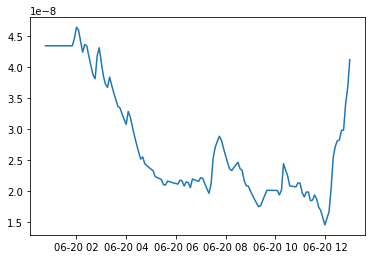



KDJ
                             K          D           J
time                                                 
2020-06-20 00:45:00  50.000000  50.000000   50.000000
2020-06-20 00:50:00  47.222222  49.074074   43.518519
2020-06-20 00:55:00  46.866097  48.338082   43.922127
2020-06-20 01:00:00  51.756885  49.477683   56.315290
2020-06-20 01:05:00  62.709718  53.888361   80.352432
...                        ...        ...         ...
2020-06-20 12:40:00  87.239886  86.535037   88.649584
2020-06-20 12:45:00  87.571689  86.880588   88.953891
2020-06-20 12:50:00  91.714459  88.491878   98.159621
2020-06-20 12:55:00  94.476306  90.486688  102.455543
2020-06-20 13:00:00  75.484204  85.485860   55.480893

[148 rows x 3 columns]


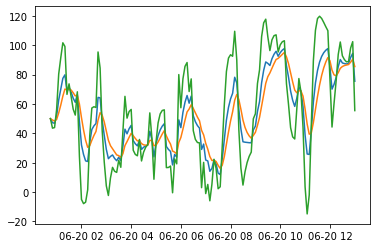



MACD
                             MACD   signal_line     histogram
time                                                         
2020-06-20 00:45:00 -1.121795e-09 -1.121795e-09  0.000000e+00
2020-06-20 00:50:00 -1.121795e-09 -1.121795e-09  0.000000e+00
2020-06-20 00:55:00 -1.429389e-09 -1.247858e-09 -1.815312e-10
2020-06-20 01:00:00 -8.121662e-10 -1.100266e-09  2.880998e-10
2020-06-20 01:05:00  7.340908e-10 -5.545864e-10  1.288677e-09
...                           ...           ...           ...
2020-06-20 12:40:00  3.401390e-08  2.191334e-08  1.210056e-08
2020-06-20 12:45:00  3.761903e-08  2.505448e-08  1.256455e-08
2020-06-20 12:50:00  4.480112e-08  2.900381e-08  1.579731e-08
2020-06-20 12:55:00  5.151298e-08  3.350564e-08  1.800734e-08
2020-06-20 13:00:00  4.820739e-08  3.644599e-08  1.176140e-08

[148 rows x 3 columns]


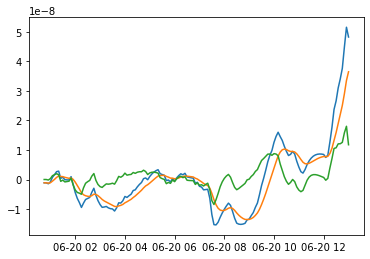



RSI
time
2020-06-20 00:45:00     0.000000
2020-06-20 00:50:00     0.000000
2020-06-20 00:55:00     0.000000
2020-06-20 01:00:00    34.935580
2020-06-20 01:05:00    59.402365
                         ...    
2020-06-20 12:40:00    81.733023
2020-06-20 12:45:00    84.734383
2020-06-20 12:50:00    90.257529
2020-06-20 12:55:00    91.437608
2020-06-20 13:00:00    53.895064
Name: close, Length: 148, dtype: float64


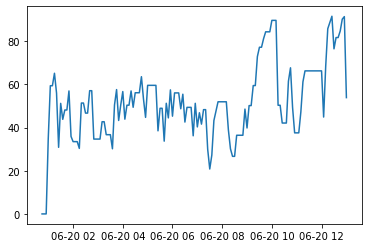



average_directional_index
                          ADX     PosDI     NegDI
time                                             
2020-06-20 02:55:00  0.232971  0.128878  0.167549
2020-06-20 03:00:00  0.198802  0.151174  0.153199
2020-06-20 03:05:00  0.186828  0.138140  0.175136
2020-06-20 03:10:00  0.187972  0.232675  0.156852
2020-06-20 03:15:00  0.188936  0.204108  0.137594
...                       ...       ...       ...
2020-06-20 12:35:00  0.474247  0.433261  0.057219
2020-06-20 12:40:00  0.518896  0.445435  0.046998
2020-06-20 12:45:00  0.565117  0.564866  0.040710
2020-06-20 12:50:00  0.607787  0.506014  0.030831
2020-06-20 12:55:00  0.543700  0.407858  0.315848

[121 rows x 3 columns]


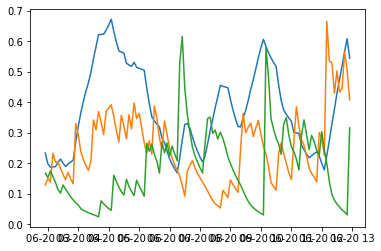



bollinger_bands
                        BB_up   BB_down      BB_width
time                                                 
2020-06-20 02:20:00  0.000006  0.000006  0.000000e+00
2020-06-20 02:25:00  0.000006  0.000006  8.944272e-10
2020-06-20 02:30:00  0.000006  0.000006  1.231174e-09
2020-06-20 02:35:00  0.000006  0.000006  1.465390e-09
2020-06-20 02:40:00  0.000006  0.000006  1.641565e-09
...                       ...       ...           ...
2020-06-20 12:40:00  0.000006  0.000006  2.492700e-08
2020-06-20 12:45:00  0.000006  0.000006  3.084507e-08
2020-06-20 12:50:00  0.000006  0.000006  3.782870e-08
2020-06-20 12:55:00  0.000006  0.000006  4.558000e-08
2020-06-20 13:00:00  0.000006  0.000006  5.250654e-08

[129 rows x 3 columns]


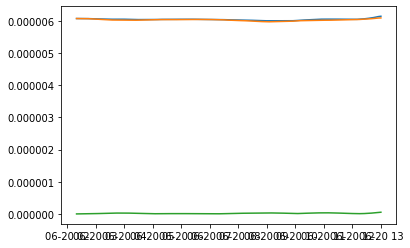



commodity_channel_index
time
2020-06-20 00:45:00         NaN
2020-06-20 00:50:00         NaN
2020-06-20 00:55:00         NaN
2020-06-20 01:00:00         NaN
2020-06-20 01:05:00         NaN
                         ...   
2020-06-20 12:40:00    2.023249
2020-06-20 12:45:00    1.962826
2020-06-20 12:50:00    2.300574
2020-06-20 12:55:00    2.190173
2020-06-20 13:00:00    1.158870
Name: CCI, Length: 148, dtype: float64


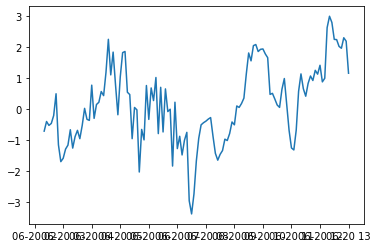



exponential_moving_average
                         open      high       low     close         volume
time                                                                      
2020-06-20 00:45:00  0.000006  0.000006  0.000006  0.000006  197645.000000
2020-06-20 00:50:00  0.000006  0.000006  0.000006  0.000006  261215.000000
2020-06-20 00:55:00  0.000006  0.000006  0.000006  0.000006  166033.769231
2020-06-20 01:00:00  0.000006  0.000006  0.000006  0.000006   86129.450000
2020-06-20 01:05:00  0.000006  0.000006  0.000006  0.000006   73395.413223
...                       ...       ...       ...       ...            ...
2020-06-20 12:40:00  0.000006  0.000006  0.000006  0.000006   96517.684593
2020-06-20 12:45:00  0.000006  0.000006  0.000006  0.000006  226639.228198
2020-06-20 12:50:00  0.000006  0.000006  0.000006  0.000006  321254.409399
2020-06-20 12:55:00  0.000006  0.000006  0.000006  0.000006  222130.803133
2020-06-20 13:00:00  0.000006  0.000006  0.000006  0.000006  234470.934

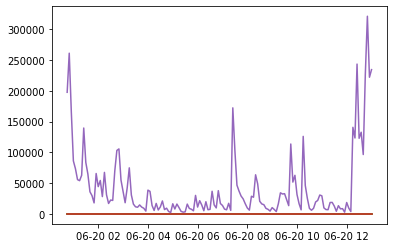



heikin_ashi
                         open      high       low     close
2020-06-20 00:45:00  0.000006  0.000006  0.000006  0.000006
2020-06-20 00:50:00  0.000006  0.000006  0.000006  0.000006
2020-06-20 00:55:00  0.000006  0.000006  0.000006  0.000006
2020-06-20 01:00:00  0.000006  0.000006  0.000006  0.000006
2020-06-20 01:05:00  0.000006  0.000006  0.000006  0.000006
...                       ...       ...       ...       ...
2020-06-20 12:40:00  0.000006  0.000006  0.000006  0.000006
2020-06-20 12:45:00  0.000006  0.000006  0.000006  0.000006
2020-06-20 12:50:00  0.000006  0.000006  0.000006  0.000006
2020-06-20 12:55:00  0.000006  0.000006  0.000006  0.000006
2020-06-20 13:00:00  0.000006  0.000006  0.000006  0.000006

[148 rows x 4 columns]


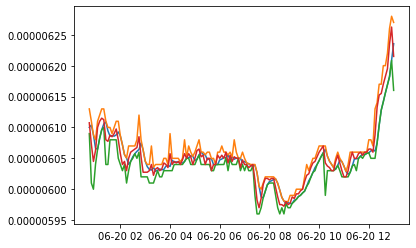



relative_volume_level
                       volume
time                         
2020-06-20 00:45:00       NaN
2020-06-20 00:50:00  0.000000
2020-06-20 00:55:00  0.000000
2020-06-20 01:00:00  0.000000
2020-06-20 01:05:00  0.000000
...                       ...
2020-06-20 12:40:00  0.076033
2020-06-20 12:45:00  0.300347
2020-06-20 12:50:00  0.277809
2020-06-20 12:55:00  0.103464
2020-06-20 13:00:00  0.130289

[148 rows x 1 columns]


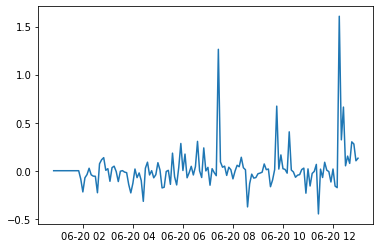



simple_moving_average
                         open      high       low     close    volume
time                                                                 
2020-06-20 00:45:00  0.000006  0.000006  0.000006  0.000006  240025.0
2020-06-20 00:50:00  0.000006  0.000006  0.000006  0.000006  240025.0
2020-06-20 00:55:00  0.000006  0.000006  0.000006  0.000006  203068.0
2020-06-20 01:00:00  0.000006  0.000006  0.000006  0.000006   85694.0
2020-06-20 01:05:00  0.000006  0.000006  0.000006  0.000006   57382.0
...                       ...       ...       ...       ...       ...
2020-06-20 12:40:00  0.000006  0.000006  0.000006  0.000006  108033.5
2020-06-20 12:45:00  0.000006  0.000006  0.000006  0.000006  185052.5
2020-06-20 12:50:00  0.000006  0.000006  0.000006  0.000006  330131.0
2020-06-20 12:55:00  0.000006  0.000006  0.000006  0.000006  270565.5
2020-06-20 13:00:00  0.000006  0.000006  0.000006  0.000006  206605.0

[148 rows x 5 columns]


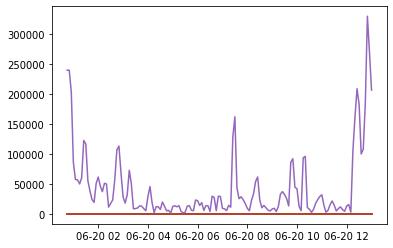



MACD_trigger
time
2020-06-20 00:45:00    0.0
2020-06-20 00:50:00    0.0
2020-06-20 00:55:00    0.0
2020-06-20 01:00:00    1.0
2020-06-20 01:05:00    1.0
                      ... 
2020-06-20 12:40:00    1.0
2020-06-20 12:45:00    1.0
2020-06-20 12:50:00    1.0
2020-06-20 12:55:00    1.0
2020-06-20 13:00:00    1.0
Name: histogram, Length: 148, dtype: float64


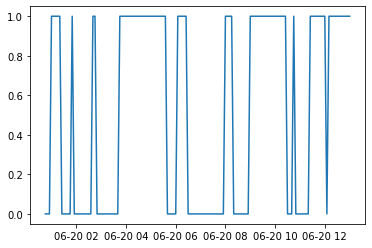



momentum_trigger
time
2020-06-20 00:45:00    0.0
2020-06-20 00:50:00    0.0
2020-06-20 00:55:00    0.0
2020-06-20 01:00:00    1.0
2020-06-20 01:05:00    1.0
                      ... 
2020-06-20 12:40:00    1.0
2020-06-20 12:45:00    1.0
2020-06-20 12:50:00    1.0
2020-06-20 12:55:00    1.0
2020-06-20 13:00:00    0.0
Length: 148, dtype: float64


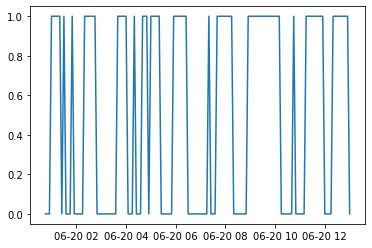



overtraded_trigger
time
2020-06-20 00:45:00    0.0
2020-06-20 00:50:00    0.0
2020-06-20 00:55:00    0.0
2020-06-20 01:00:00    1.0
2020-06-20 01:05:00    1.0
                      ... 
2020-06-20 12:40:00    0.0
2020-06-20 12:45:00    1.0
2020-06-20 12:50:00    1.0
2020-06-20 12:55:00    1.0
2020-06-20 13:00:00    0.0
Name: close, Length: 148, dtype: float64


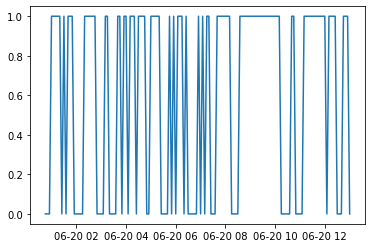



real_trigger
time
2020-06-20 00:45:00    1.0
2020-06-20 00:50:00    0.0
2020-06-20 00:55:00    0.0
2020-06-20 01:00:00    1.0
2020-06-20 01:05:00    1.0
                      ... 
2020-06-20 12:40:00    0.0
2020-06-20 12:45:00    1.0
2020-06-20 12:50:00    1.0
2020-06-20 12:55:00    1.0
2020-06-20 13:00:00    0.0
Length: 148, dtype: float64


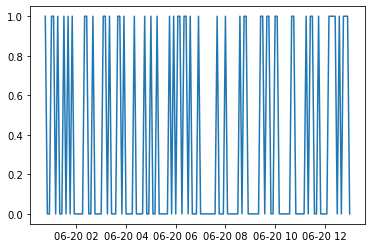



relative_volume_level_trigger
                     volume
time                       
2020-06-20 00:45:00     0.0
2020-06-20 00:50:00     0.0
2020-06-20 00:55:00     0.0
2020-06-20 01:00:00     0.0
2020-06-20 01:05:00     0.0
...                     ...
2020-06-20 12:40:00     0.0
2020-06-20 12:45:00     0.0
2020-06-20 12:50:00     0.0
2020-06-20 12:55:00     0.0
2020-06-20 13:00:00     0.0

[148 rows x 1 columns]


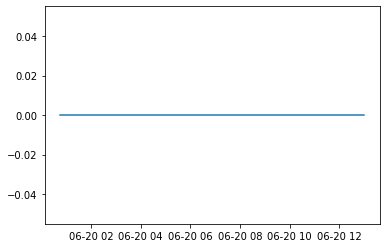



trend_strength_negative_trigger
time
2020-06-20 02:55:00    1.0
2020-06-20 03:00:00    1.0
2020-06-20 03:05:00    1.0
2020-06-20 03:10:00    0.0
2020-06-20 03:15:00    0.0
                      ... 
2020-06-20 12:35:00    0.0
2020-06-20 12:40:00    0.0
2020-06-20 12:45:00    0.0
2020-06-20 12:50:00    0.0
2020-06-20 12:55:00    0.0
Length: 121, dtype: float64


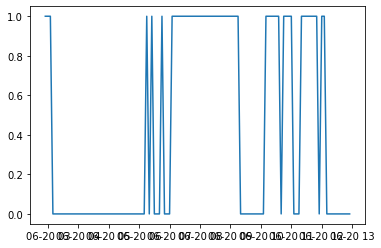



trend_strength_positive_trigger
time
2020-06-20 02:55:00    0.0
2020-06-20 03:00:00    0.0
2020-06-20 03:05:00    0.0
2020-06-20 03:10:00    1.0
2020-06-20 03:15:00    1.0
                      ... 
2020-06-20 12:35:00    1.0
2020-06-20 12:40:00    1.0
2020-06-20 12:45:00    1.0
2020-06-20 12:50:00    1.0
2020-06-20 12:55:00    1.0
Length: 121, dtype: float64


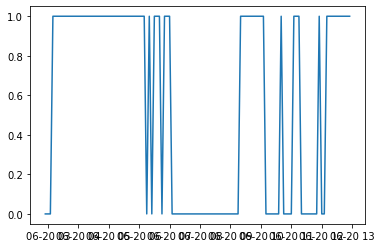



trend_strength_trigger
time
2020-06-20 02:55:00    0.0
2020-06-20 03:00:00    0.0
2020-06-20 03:05:00    0.0
2020-06-20 03:10:00    0.0
2020-06-20 03:15:00    0.0
                      ... 
2020-06-20 12:35:00    1.0
2020-06-20 12:40:00    1.0
2020-06-20 12:45:00    1.0
2020-06-20 12:50:00    1.0
2020-06-20 12:55:00    1.0
Name: ADX, Length: 121, dtype: float64


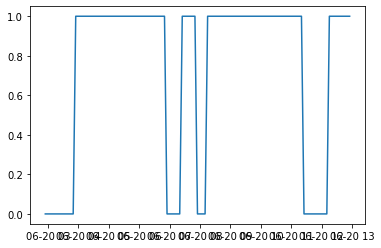



trend_trigger
time
2020-06-20 00:45:00    1.0
2020-06-20 00:50:00    0.0
2020-06-20 00:55:00    0.0
2020-06-20 01:00:00    1.0
2020-06-20 01:05:00    1.0
                      ... 
2020-06-20 12:40:00    0.0
2020-06-20 12:45:00    1.0
2020-06-20 12:50:00    1.0
2020-06-20 12:55:00    1.0
2020-06-20 13:00:00    0.0
Length: 148, dtype: float64


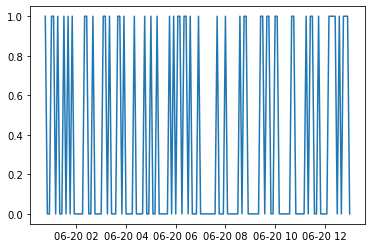



volatility_trigger
time
2020-06-20 00:45:00    0.0
2020-06-20 00:50:00    0.0
2020-06-20 00:55:00    0.0
2020-06-20 01:00:00    0.0
2020-06-20 01:05:00    0.0
                      ... 
2020-06-20 12:40:00    1.0
2020-06-20 12:45:00    1.0
2020-06-20 12:50:00    1.0
2020-06-20 12:55:00    1.0
2020-06-20 13:00:00    1.0
Length: 148, dtype: float64


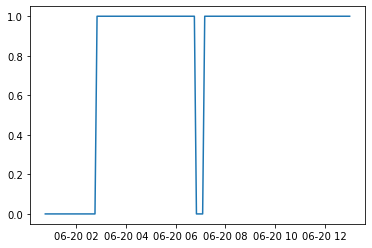





pair:  KNCBTC
interval:  5m
ATR
time
2020-06-20 00:45:00    1.045636e-06
2020-06-20 00:50:00    1.045636e-06
2020-06-20 00:55:00    1.045636e-06
2020-06-20 01:00:00    1.045636e-06
2020-06-20 01:05:00    1.045636e-06
                           ...     
2020-06-20 12:40:00    6.592300e-07
2020-06-20 12:45:00    6.471421e-07
2020-06-20 12:50:00    6.352034e-07
2020-06-20 12:55:00    6.684031e-07
2020-06-20 13:00:00    7.049458e-07
Length: 148, dtype: float64


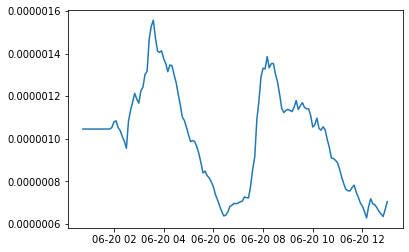



KDJ
                             K          D           J
time                                                 
2020-06-20 00:45:00  49.404762  49.801587   48.611111
2020-06-20 00:50:00  51.984127  50.529101   54.894180
2020-06-20 00:55:00  67.240354  56.099518   89.522026
2020-06-20 01:00:00  76.047560  62.748866  102.644949
2020-06-20 01:05:00  76.250982  67.249571   94.253803
...                        ...        ...         ...
2020-06-20 12:40:00  89.167836  76.283141  114.937226
2020-06-20 12:45:00  82.308472  78.291584   90.342247
2020-06-20 12:50:00  84.573169  80.385446   92.948616
2020-06-20 12:55:00  89.546241  83.439044  101.760635
2020-06-20 13:00:00  85.724892  84.200993   88.772688

[148 rows x 3 columns]


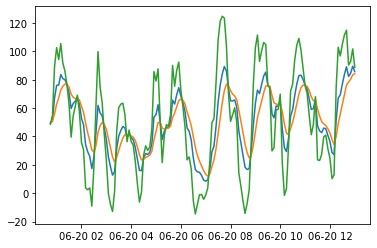



MACD
                             MACD   signal_line     histogram
time                                                         
2020-06-20 00:45:00  2.019231e-09  2.019231e-09  0.000000e+00
2020-06-20 00:50:00  2.019231e-09  2.019231e-09  0.000000e+00
2020-06-20 00:55:00  1.838797e-08  8.727731e-09  9.660240e-09
2020-06-20 01:00:00  4.199028e-08  1.999553e-08  2.199475e-08
2020-06-20 01:05:00  1.160074e-07  4.855689e-08  6.745051e-08
...                           ...           ...           ...
2020-06-20 12:40:00  2.548581e-07  2.053939e-07  4.946423e-08
2020-06-20 12:45:00  2.336957e-07  2.110543e-07  2.264142e-08
2020-06-20 12:50:00  2.399790e-07  2.168392e-07  2.313976e-08
2020-06-20 12:55:00  3.091747e-07  2.353063e-07  7.386843e-08
2020-06-20 13:00:00  3.383264e-07  2.559103e-07  8.241603e-08

[148 rows x 3 columns]


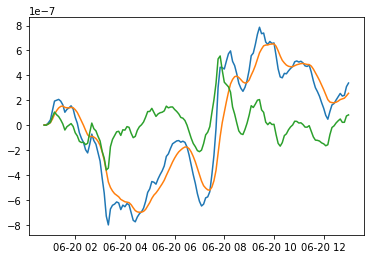



RSI
time
2020-06-20 00:45:00    100.000000
2020-06-20 00:50:00    100.000000
2020-06-20 00:55:00    100.000000
2020-06-20 01:00:00    100.000000
2020-06-20 01:05:00    100.000000
                          ...    
2020-06-20 12:40:00     65.532840
2020-06-20 12:45:00     50.381622
2020-06-20 12:50:00     57.765806
2020-06-20 12:55:00     70.867000
2020-06-20 13:00:00     63.594939
Name: close, Length: 148, dtype: float64


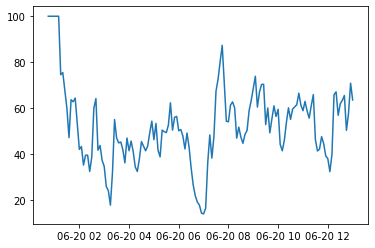



average_directional_index
                          ADX     PosDI     NegDI
time                                             
2020-06-20 02:55:00  0.400284  0.104546  0.308096
2020-06-20 03:00:00  0.433882  0.091822  0.395060
2020-06-20 03:05:00  0.467966  0.075668  0.374223
2020-06-20 03:10:00  0.508894  0.064479  0.447213
2020-06-20 03:15:00  0.544521  0.053249  0.382792
...                       ...       ...       ...
2020-06-20 12:35:00  0.217897  0.167893  0.129562
2020-06-20 12:40:00  0.196330  0.149230  0.133363
2020-06-20 12:45:00  0.177639  0.131748  0.117740
2020-06-20 12:50:00  0.217756  0.294748  0.103959
2020-06-20 12:55:00  0.254174  0.250740  0.085623

[121 rows x 3 columns]


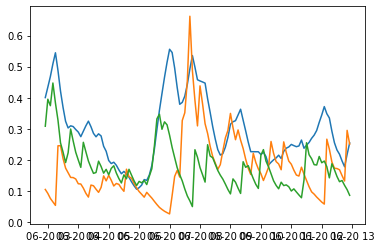



bollinger_bands
                        BB_up   BB_down      BB_width
time                                                 
2020-06-20 02:20:00  0.000137  0.000137  0.000000e+00
2020-06-20 02:25:00  0.000137  0.000137  1.050952e-08
2020-06-20 02:30:00  0.000138  0.000137  2.643940e-08
2020-06-20 02:35:00  0.000138  0.000138  6.033544e-08
2020-06-20 02:40:00  0.000138  0.000138  1.007490e-07
...                       ...       ...           ...
2020-06-20 12:40:00  0.000137  0.000137  2.665345e-07
2020-06-20 12:45:00  0.000137  0.000137  2.352967e-07
2020-06-20 12:50:00  0.000137  0.000137  2.107408e-07
2020-06-20 12:55:00  0.000137  0.000137  1.907932e-07
2020-06-20 13:00:00  0.000137  0.000137  1.873736e-07

[129 rows x 3 columns]


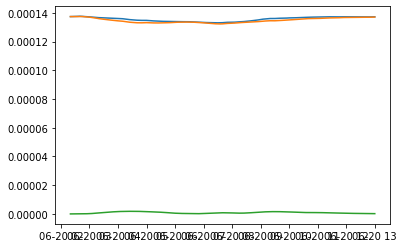



commodity_channel_index
time
2020-06-20 00:45:00         NaN
2020-06-20 00:50:00         NaN
2020-06-20 00:55:00         NaN
2020-06-20 01:00:00         NaN
2020-06-20 01:05:00         NaN
                         ...   
2020-06-20 12:40:00    1.289857
2020-06-20 12:45:00    0.802597
2020-06-20 12:50:00    0.934901
2020-06-20 12:55:00    1.903576
2020-06-20 13:00:00    1.942480
Name: CCI, Length: 148, dtype: float64


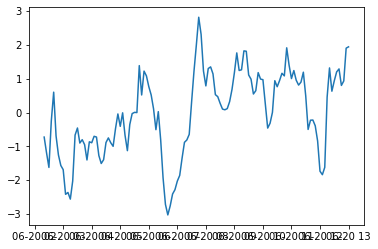



exponential_moving_average
                         open      high       low     close         volume
time                                                                      
2020-06-20 00:45:00  0.000136  0.000136  0.000135  0.000136   22970.000000
2020-06-20 00:50:00  0.000136  0.000136  0.000136  0.000136   10441.250000
2020-06-20 00:55:00  0.000136  0.000136  0.000136  0.000136   39389.230769
2020-06-20 01:00:00  0.000136  0.000137  0.000136  0.000137   45851.525000
2020-06-20 01:05:00  0.000137  0.000138  0.000137  0.000138  127062.710744
...                       ...       ...       ...       ...            ...
2020-06-20 12:40:00  0.000137  0.000138  0.000137  0.000138   14715.245447
2020-06-20 12:45:00  0.000138  0.000138  0.000137  0.000137    8622.415149
2020-06-20 12:50:00  0.000138  0.000138  0.000137  0.000137    4972.138383
2020-06-20 12:55:00  0.000137  0.000138  0.000137  0.000138   57050.046128
2020-06-20 13:00:00  0.000138  0.000138  0.000138  0.000138   45712.682

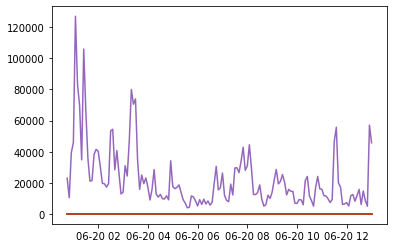



heikin_ashi
                         open      high       low     close
2020-06-20 00:45:00  0.000136  0.000136  0.000135  0.000136
2020-06-20 00:50:00  0.000136  0.000136  0.000136  0.000136
2020-06-20 00:55:00  0.000136  0.000136  0.000136  0.000136
2020-06-20 01:00:00  0.000136  0.000137  0.000136  0.000137
2020-06-20 01:05:00  0.000136  0.000139  0.000136  0.000138
...                       ...       ...       ...       ...
2020-06-20 12:40:00  0.000137  0.000138  0.000137  0.000138
2020-06-20 12:45:00  0.000137  0.000138  0.000137  0.000137
2020-06-20 12:50:00  0.000137  0.000138  0.000137  0.000137
2020-06-20 12:55:00  0.000137  0.000138  0.000137  0.000138
2020-06-20 13:00:00  0.000138  0.000138  0.000138  0.000138

[148 rows x 4 columns]


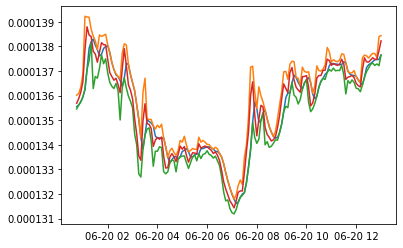



relative_volume_level
                       volume
time                         
2020-06-20 00:45:00       NaN
2020-06-20 00:50:00  0.000000
2020-06-20 00:55:00  0.000000
2020-06-20 01:00:00  0.000000
2020-06-20 01:05:00  0.000000
...                       ...
2020-06-20 12:40:00 -0.202215
2020-06-20 12:45:00 -0.299226
2020-06-20 12:50:00  0.008154
2020-06-20 12:55:00  0.519150
2020-06-20 13:00:00  0.201748

[148 rows x 1 columns]


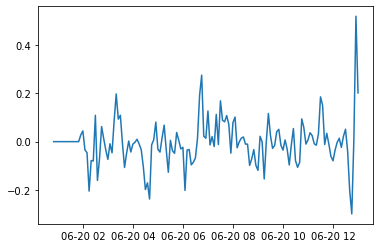



simple_moving_average
                         open      high       low     close    volume
time                                                                 
2020-06-20 00:45:00  0.000136  0.000136  0.000136  0.000136   14617.5
2020-06-20 00:50:00  0.000136  0.000136  0.000136  0.000136   14617.5
2020-06-20 00:55:00  0.000136  0.000136  0.000136  0.000136   29260.0
2020-06-20 01:00:00  0.000136  0.000137  0.000136  0.000137   50609.0
2020-06-20 01:05:00  0.000137  0.000138  0.000137  0.000138  108065.0
...                       ...       ...       ...       ...       ...
2020-06-20 12:40:00  0.000137  0.000138  0.000137  0.000138   10121.5
2020-06-20 12:45:00  0.000138  0.000138  0.000137  0.000137   12311.5
2020-06-20 12:50:00  0.000138  0.000138  0.000137  0.000137    4361.5
2020-06-20 12:55:00  0.000137  0.000138  0.000137  0.000138   43118.0
2020-06-20 13:00:00  0.000138  0.000138  0.000138  0.000138   61566.5

[148 rows x 5 columns]


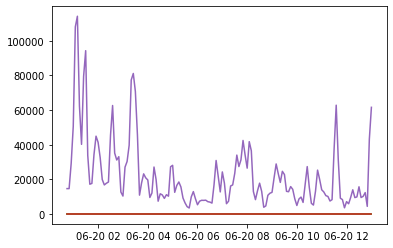



MACD_trigger
time
2020-06-20 00:45:00    0.0
2020-06-20 00:50:00    0.0
2020-06-20 00:55:00    1.0
2020-06-20 01:00:00    1.0
2020-06-20 01:05:00    1.0
                      ... 
2020-06-20 12:40:00    1.0
2020-06-20 12:45:00    1.0
2020-06-20 12:50:00    1.0
2020-06-20 12:55:00    1.0
2020-06-20 13:00:00    1.0
Name: histogram, Length: 148, dtype: float64


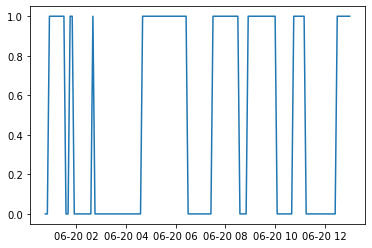



momentum_trigger
time
2020-06-20 00:45:00    0.0
2020-06-20 00:50:00    1.0
2020-06-20 00:55:00    1.0
2020-06-20 01:00:00    1.0
2020-06-20 01:05:00    1.0
                      ... 
2020-06-20 12:40:00    1.0
2020-06-20 12:45:00    1.0
2020-06-20 12:50:00    1.0
2020-06-20 12:55:00    1.0
2020-06-20 13:00:00    1.0
Length: 148, dtype: float64


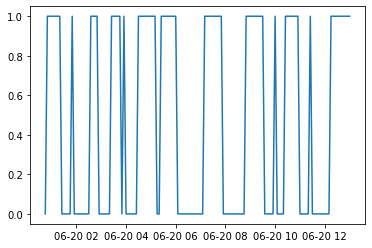



overtraded_trigger
time
2020-06-20 00:45:00    0.0
2020-06-20 00:50:00    0.0
2020-06-20 00:55:00    0.0
2020-06-20 01:00:00    0.0
2020-06-20 01:05:00    0.0
                      ... 
2020-06-20 12:40:00    1.0
2020-06-20 12:45:00    0.0
2020-06-20 12:50:00    0.0
2020-06-20 12:55:00    1.0
2020-06-20 13:00:00    1.0
Name: close, Length: 148, dtype: float64


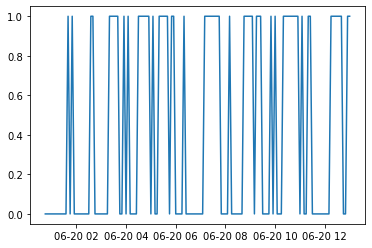



real_trigger
time
2020-06-20 00:45:00    1.0
2020-06-20 00:50:00    0.0
2020-06-20 00:55:00    1.0
2020-06-20 01:00:00    1.0
2020-06-20 01:05:00    1.0
                      ... 
2020-06-20 12:40:00    1.0
2020-06-20 12:45:00    0.0
2020-06-20 12:50:00    1.0
2020-06-20 12:55:00    1.0
2020-06-20 13:00:00    0.0
Length: 148, dtype: float64


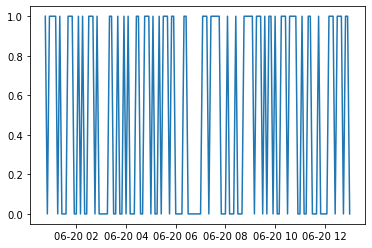



relative_volume_level_trigger
                     volume
time                       
2020-06-20 00:45:00     0.0
2020-06-20 00:50:00     0.0
2020-06-20 00:55:00     0.0
2020-06-20 01:00:00     0.0
2020-06-20 01:05:00     0.0
...                     ...
2020-06-20 12:40:00     0.0
2020-06-20 12:45:00     0.0
2020-06-20 12:50:00     0.0
2020-06-20 12:55:00     0.0
2020-06-20 13:00:00     0.0

[148 rows x 1 columns]


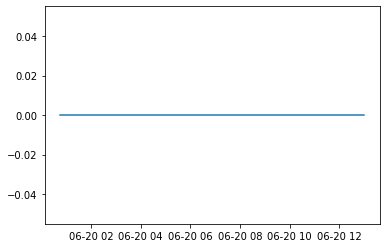



trend_strength_negative_trigger
time
2020-06-20 02:55:00    1.0
2020-06-20 03:00:00    1.0
2020-06-20 03:05:00    1.0
2020-06-20 03:10:00    1.0
2020-06-20 03:15:00    1.0
                      ... 
2020-06-20 12:35:00    0.0
2020-06-20 12:40:00    0.0
2020-06-20 12:45:00    0.0
2020-06-20 12:50:00    0.0
2020-06-20 12:55:00    0.0
Length: 121, dtype: float64


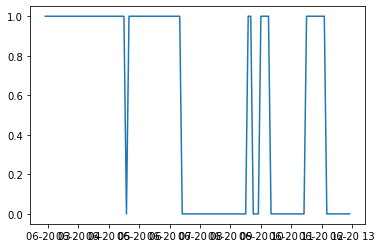



trend_strength_positive_trigger
time
2020-06-20 02:55:00    0.0
2020-06-20 03:00:00    0.0
2020-06-20 03:05:00    0.0
2020-06-20 03:10:00    0.0
2020-06-20 03:15:00    0.0
                      ... 
2020-06-20 12:35:00    1.0
2020-06-20 12:40:00    1.0
2020-06-20 12:45:00    1.0
2020-06-20 12:50:00    1.0
2020-06-20 12:55:00    1.0
Length: 121, dtype: float64


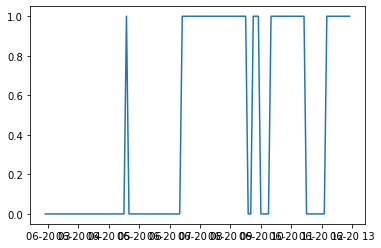



trend_strength_trigger
time
2020-06-20 02:55:00    1.0
2020-06-20 03:00:00    1.0
2020-06-20 03:05:00    1.0
2020-06-20 03:10:00    1.0
2020-06-20 03:15:00    1.0
                      ... 
2020-06-20 12:35:00    0.0
2020-06-20 12:40:00    0.0
2020-06-20 12:45:00    0.0
2020-06-20 12:50:00    0.0
2020-06-20 12:55:00    1.0
Name: ADX, Length: 121, dtype: float64


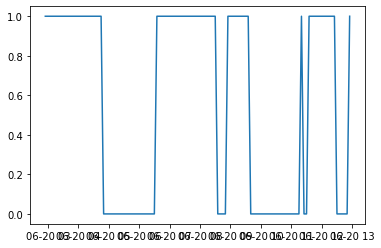



trend_trigger
time
2020-06-20 00:45:00    1.0
2020-06-20 00:50:00    0.0
2020-06-20 00:55:00    1.0
2020-06-20 01:00:00    1.0
2020-06-20 01:05:00    1.0
                      ... 
2020-06-20 12:40:00    1.0
2020-06-20 12:45:00    0.0
2020-06-20 12:50:00    1.0
2020-06-20 12:55:00    1.0
2020-06-20 13:00:00    0.0
Length: 148, dtype: float64


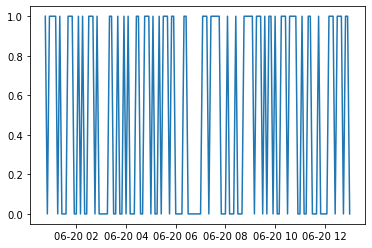



volatility_trigger
time
2020-06-20 00:45:00    0.0
2020-06-20 00:50:00    0.0
2020-06-20 00:55:00    0.0
2020-06-20 01:00:00    0.0
2020-06-20 01:05:00    0.0
                      ... 
2020-06-20 12:40:00    1.0
2020-06-20 12:45:00    1.0
2020-06-20 12:50:00    1.0
2020-06-20 12:55:00    1.0
2020-06-20 13:00:00    1.0
Length: 148, dtype: float64


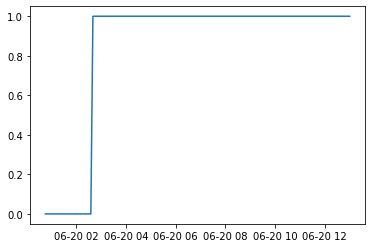

In [5]:
client = Client(api_key, api_secret)

crypto_bot = Cryptocurrency_bot(client=client, 
                                traded_asset_symbols=traded_asset_symbols, 
                                intervals=intervals, 
                                raw_price=raw_price, 
                                initial_plot=initial_plot)

In [6]:
def process_message(msg):
    global crypto_bot
    four_hours = 14400
    milliseconds = 1000
    percentage_to_trade = 0.9999

    msg = msg['data']['k']
    symbol = msg['s']
    interval = msg['i']
    pair = crypto_bot.pairs[symbol]
    pair_at_interval = pair.interval[interval]
    dataset = pair_at_interval.dataset
    precision = pair.info.precision
    if symbol in crypto_bot.pairs.keys():
        last_data = \
            pd.DataFrame([["{:0.0{}f}".format(float(msg['o']), precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['h']), precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['l']), precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['c']), precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['v']), precision).rstrip('0').rstrip('.')]], 
                         index=[datetime.datetime.fromtimestamp(int(msg['t'] / milliseconds) - four_hours)], 
                         columns=['open', 'high', 'low', 'close', 'volume'])

        last_data.index.name = 'time'

        if dataset.index[-1] == last_data.index[-1]:
            dataset = dataset.iloc[:-1].append(last_data).iloc[-1000:]
        else:
            dataset = dataset.append(last_data).iloc[-1000:]

        pair_at_interval.dataset = dataset
        pair_at_interval.indicators.update(dataset, plot=False)
        pair.info.calculate_balance()
        pair.info.print_balance()

        if symbol == crypto_bot.traded_pair_symbol:
            volatility_trigger = pair_at_interval.indicators.indicators.volatility_trigger.value.iloc[-1]
            MACD_trigger = pair_at_interval.indicators.indicators.MACD_trigger.value.iloc[-1]
            real_trigger = pair_at_interval.indicators.indicators.real_trigger.value.iloc[-1]
            momentum_trigger = pair_at_interval.indicators.indicators.momentum_trigger.value.iloc[-1]

            if pair.state == 'exit':

                if pair.position == 'sell' and \
                        volatility_trigger and \
                        MACD_trigger and \
                        real_trigger and \
                        momentum_trigger:

                    pair.trade(percentage_to_trade=percentage_to_trade)

                elif pair.position == 'buy' and \
                        volatility_trigger and \
                        not MACD_trigger and \
                        not real_trigger and \
                        not momentum_trigger:

                    pair.trade(percentage_to_trade=percentage_to_trade)

            elif pair.state == 'entry':

                if pair.position == 'sell' and \
                        volatility_trigger and \
                        MACD_trigger and \
                        real_trigger and \
                        momentum_trigger:

                    pair.trade(percentage_to_trade=percentage_to_trade)

                elif pair.position == 'buy' and \
                        volatility_trigger and \
                        not MACD_trigger and \
                        not real_trigger and \
                        not momentum_trigger:

                    pair.trade(percentage_to_trade=percentage_to_trade)


bm = BinanceSocketManager(client, user_timeout=43200)

sockets = []

for interval in intervals:
    for symbol in crypto_bot.pairs.keys():
        sockets.append(symbol.lower() + '@kline_' + interval)

conn_key = bm.start_multiplex_socket(sockets, process_message)

bm.start()


while True:
    time.sleep(30)

    crypto_bot.assets = dict.fromkeys(crypto_bot.assets.keys(), 0)

    for pair in crypto_bot.pairs.keys():
        crypto_bot.pairs[pair].info.calculate_balance()
        crypto_bot.pairs[pair].info.calculate_position()

    for asset in crypto_bot.assets.keys():
        for pair in crypto_bot.pairs.keys():
            if crypto_bot.pairs[pair].info.base_asset == asset:
                if crypto_bot.pairs[pair].interval['5m'].indicators.indicators.real_trigger.value.iloc[-1] and \
                        crypto_bot.pairs[pair].interval['5m'].indicators.indicators.relative_volume_levels_trigger.value.iloc[-1]:

                    crypto_bot.assets[asset] += 1
                else:
                    crypto_bot.assets[asset] -= 1

            elif crypto_bot.pairs[pair].info.quote_asset == asset:
                if crypto_bot.pairs[pair].interval['5m'].indicators.indicators.real_trigger.value.iloc[-1] and \
                        crypto_bot.pairs[pair].interval['5m'].indicators.indicators.relative_volume_levels_trigger.value.iloc[-1]:

                    crypto_bot.assets[asset] -= 1
                else:
                    crypto_bot.assets[asset] += 1

    best_assets = [asset for asset in crypto_bot.assets.keys() if crypto_bot.assets[asset] > 0]
    print('best_assets: ', best_assets)

    if best_assets != [] and \
            not (crypto_bot.pairs[crypto_bot.traded_pair_symbol].info.base_asset in best_assets or \
            crypto_bot.pairs[crypto_bot.traded_pair_symbol].info.quote_asset in best_assets):

        if crypto_bot.pairs[crypto_bot.traded_pair_symbol].position == 'buy':
            asset = crypto_bot.pairs[crypto_bot.traded_pair_symbol].info.base_asset
        elif crypto_bot.pairs[crypto_bot.traded_pair_symbol].position == 'sell':
            asset = crypto_bot.pairs[crypto_bot.traded_pair_symbol].info.quote_asset

        target_symbols = [pair for pair in crypto_bot.pairs.keys() \
                          if asset in pair and any([asset in pair for asset in best_assets])]

        target_symbol = target_symbols[0]
        crypto_bot.pairs[target_symbol].state = 'exit'

        if crypto_bot.pairs[target_symbol].info.base_asset == asset:
            crypto_bot.pairs[target_symbol].position = 'buy'
            crypto_bot.traded_asset_symbol = crypto_bot.pairs[target_symbol].info.base_asset
        elif crypto_bot.pairs[target_symbol].info.quote_asset == asset:
            crypto_bot.pairs[target_symbol].position = 'sell'
            crypto_bot.traded_asset_symbol = crypto_bot.pairs[target_symbol].info.quote_asset

        crypto_bot.traded_pair_symbol = target_symbol



pair:  DATABTC
base_asset_balance:  0
quote_asset_balance:  0.00002428
pair_last_price:  0.00000619
pair_buy_balance:  3.92245557
pair_sell_balance:  0
pair_combined_base_balance:  3.92245557
pair_combined_quote_balance:  0.00002428




pair:  DATABTC
base_asset_balance:  0
quote_asset_balance:  0.00002428
pair_last_price:  0.00000619
pair_buy_balance:  3.92245557
pair_sell_balance:  0
pair_combined_base_balance:  3.92245557
pair_combined_quote_balance:  0.00002428




pair:  DATABTC
base_asset_balance:  0
quote_asset_balance:  0.00002428
pair_last_price:  0.0000062
pair_buy_balance:  3.91612903
pair_sell_balance:  0
pair_combined_base_balance:  3.91612903
pair_combined_quote_balance:  0.00002428




pair:  KNCBTC
base_asset_balance:  57.9514
quote_asset_balance:  0.00002428
pair_last_price:  0.00013835
pair_buy_balance:  0.17549693
pair_sell_balance:  0.00801758
pair_combined_base_balance:  58.12689693
pair_combined_quote_balance:  0.00804186




pair:  DATABTC
base_asset_balance:  

AttributeError: 'Cryptocurrency_pair_info' object has no attribute 'calculate_position'

In [ ]:
# --- Development separation --- #

In [ ]:
'''
def process_message(msg):
    global symbols, traded_symbol
    four_hours = 14400
    milliseconds = 1000

    msg = msg['data']['k']
    symbol = msg['s']
    dataset = symbols[symbol].dataset
    quote_asset_precision = symbols[symbol].quote_asset_precision
    if symbol in symbols.keys():
        last_data = \
            pd.DataFrame([["{:0.0{}f}".format(float(msg['o']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['h']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['l']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['c']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['v']), quote_asset_precision).rstrip('0').rstrip('.')]], 
                         index=[datetime.datetime.fromtimestamp(int(msg['t'] / milliseconds) - four_hours)], 
                         columns=['open', 'high', 'low', 'close', 'volume'])

        last_data.index.name = 'time'

        if dataset.index[-1] == last_data.index[-1]:
            dataset = dataset.iloc[:-1].append(last_data).iloc[-1000:]
        else:
            dataset = dataset.append(last_data).iloc[-1000:]

        symbols[symbol].dataset = dataset
        symbols[symbol].calculate_indicators()

        if symbol == traded_symbol:
            if symbols[symbol].state == 'exit':

                if symbols[symbol].position == 'sell' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        symbols[symbol].MACD_trigger.iloc[-1] and \
                        symbols[symbol].real_trigger.iloc[-1] and \
                        symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

                elif symbols[symbol].position == 'buy' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        not symbols[symbol].MACD_trigger.iloc[-1] and \
                        not symbols[symbol].real_trigger.iloc[-1] and \
                        not symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

            elif symbols[symbol].state == 'entry':

                if symbols[symbol].position == 'sell' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        symbols[symbol].MACD_trigger.iloc[-1] and \
                        symbols[symbol].real_trigger.iloc[-1] and \
                        symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

                elif symbols[symbol].position == 'buy' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        not symbols[symbol].MACD_trigger.iloc[-1] and \
                        not symbols[symbol].real_trigger.iloc[-1] and \
                        not symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

bm = BinanceSocketManager(client, user_timeout=43200)
conn_key = bm.start_multiplex_socket([symbol.lower() + '@kline_' + interval for symbol in symbols.keys()], 
                                     process_message)
bm.start()
'''

In [ ]:
#bm.stop_socket(conn_key)
#bm.close()
#reactor.stop()



pair:  DATABTC
base_asset_balance:  0
quote_asset_balance:  0.00002428
pair_last_price:  0.00000618
pair_buy_balance:  3.92880259
pair_sell_balance:  0
pair_combined_base_balance:  3.92880259
pair_combined_quote_balance:  0.00002428




pair:  KNCBTC
base_asset_balance:  57.9514
quote_asset_balance:  0.00002428
pair_last_price:  0.00013819
pair_buy_balance:  0.17570012
pair_sell_balance:  0.0080083
pair_combined_base_balance:  58.12710012
pair_combined_quote_balance:  0.00803258




pair:  DATABTC
base_asset_balance:  0
quote_asset_balance:  0.00002428
pair_last_price:  0.00000619
pair_buy_balance:  3.92245557
pair_sell_balance:  0
pair_combined_base_balance:  3.92245557
pair_combined_quote_balance:  0.00002428




pair:  KNCBTC
base_asset_balance:  57.9514
quote_asset_balance:  0.00002428
pair_last_price:  0.00013819
pair_buy_balance:  0.17570012
pair_sell_balance:  0.0080083
pair_combined_base_balance:  58.12710012
pair_combined_quote_balance:  0.00803258




pair:  DATABTC
base_as